## Dataset link
https://www.kaggle.com/datasets/shreyashgupta88/american-sign-language-thresholded

In [2]:
#Imports

import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import time

import os
import shutil
import pathlib
from importlib import reload
from PIL import Image
import skimage
from tqdm import tqdm

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, 'util')
import vcpi_util

In [3]:
print(torch.__version__)

2.3.1+cu121


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Data Preparation

In [5]:
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1
DATASET_PATH = 'signs'
BATCH_SIZE = 32
EPOCHS = 10



path_dest = os.path.join('dataset')
train_path_dest = os.path.join(path_dest, 'trainSet')
validation_path_dest = os.path.join(path_dest, 'validSet')
test_path_dest = os.path.join(path_dest, 'testSet')

In [6]:
# function to separate the dataset into training, validation and test sets on another 3 folders. 
# It is assumed that the dataset is divided into classes
def separate_dataset(DATASET_PATH, train_path_dest, validation_path_dest, test_path_dest, train_split=0.6, validation_split=0.2, test_split=0.2):
    if not os.path.exists(DATASET_PATH):
        print('The dataset folder does not exist')
        return
    
    if(train_split < 0 or train_split > 1 or validation_split < 0 or validation_split > 1 or test_split < 0 or test_split > 1):
        print('One of the splits is less than or equal to 0 or greater than 1')
        return
    
    # create the folders if they don't exist
    if not os.path.exists(train_path_dest) and train_split > 0:
        os.makedirs(train_path_dest)
    if not os.path.exists(validation_path_dest) and validation_split > 0:
        os.makedirs(validation_path_dest)
    if not os.path.exists(test_path_dest) and test_split > 0:
        os.makedirs(test_path_dest)

    # get the list of files in the dataset
    files = os.listdir(DATASET_PATH)

    for class_name in files:
        # get the list of files in the class
        class_files = os.listdir(os.path.join(DATASET_PATH, class_name))
        # get the number of files in the class
        num_files = len(class_files)
        # calculate the number of files for each set
        num_train_files = int(num_files * train_split)
        num_validation_files = int(num_files * validation_split)
        num_test_files = num_files - num_train_files - num_validation_files
        
        abc = 'abcdefghijklmnopqrstuvwxyz'
        
        if not os.path.exists(os.path.join(train_path_dest, abc[int(class_name)])):
            os.makedirs(os.path.join(train_path_dest, abc[int(class_name)]))
        
        if not os.path.exists(os.path.join(validation_path_dest, abc[int(class_name)])):
            os.makedirs(os.path.join(validation_path_dest, abc[int(class_name)]))
        
        if not os.path.exists(os.path.join(test_path_dest, abc[int(class_name)])):
            os.makedirs(os.path.join(test_path_dest, abc[int(class_name)]))
        
        for i in range(num_files):
            # select a random file from the class
            file = class_files[np.random.randint(num_files)]
            num_files -= 1
            # remove the file from the list, but not from the original folder
            class_files.remove(file)
            fType = file.split('.')[-1]
            
            if i < num_train_files:
                shutil.copyfile(os.path.join(DATASET_PATH, class_name, file), os.path.join(train_path_dest, abc[int(class_name)], f'{i}.{fType}'))
            
            elif i < num_train_files + num_validation_files:
                shutil.copyfile(os.path.join(DATASET_PATH, class_name, file), os.path.join(validation_path_dest, abc[int(class_name)], f'{i-num_train_files}.{fType}'))
            else:
                shutil.copyfile(os.path.join(DATASET_PATH, class_name, file), os.path.join(test_path_dest, abc[int(class_name)], f'{i-num_train_files-num_validation_files}.{fType}'))
                
                
def remove_directories(folders):
    for folder in folders:
        if os.path.exists(folder):
            shutil.rmtree(folder)
        else:
            print(f'The folder "{folder}" does not exist')

In [17]:
separate_dataset(DATASET_PATH, train_path_dest, validation_path_dest, test_path_dest, 0.7,0.2,0.1)

In [13]:
remove_directories([path_dest])

In [7]:
# original images are 256x256, with 3 channels (RGB, although they appear to be grayscale).
# make the images grayscale, resize them to 28x28. I resized to this size because my device is not that powerful
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=NUM_CHANNELS),
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.ToTensor()
])

train_set = torchvision.datasets.ImageFolder(root=train_path_dest, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

validation_set = torchvision.datasets.ImageFolder(root=validation_path_dest, transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE)

test_set = torchvision.datasets.ImageFolder(root=test_path_dest, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
print(train_set.classes)
print(validation_set.classes)
print(test_set.classes)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [9]:
reload(vcpi_util)

<module 'vcpi_util' from 'c:\\Users\\User\\Desktop\\VC_INDIVIDUAL\\util\\vcpi_util.py'>

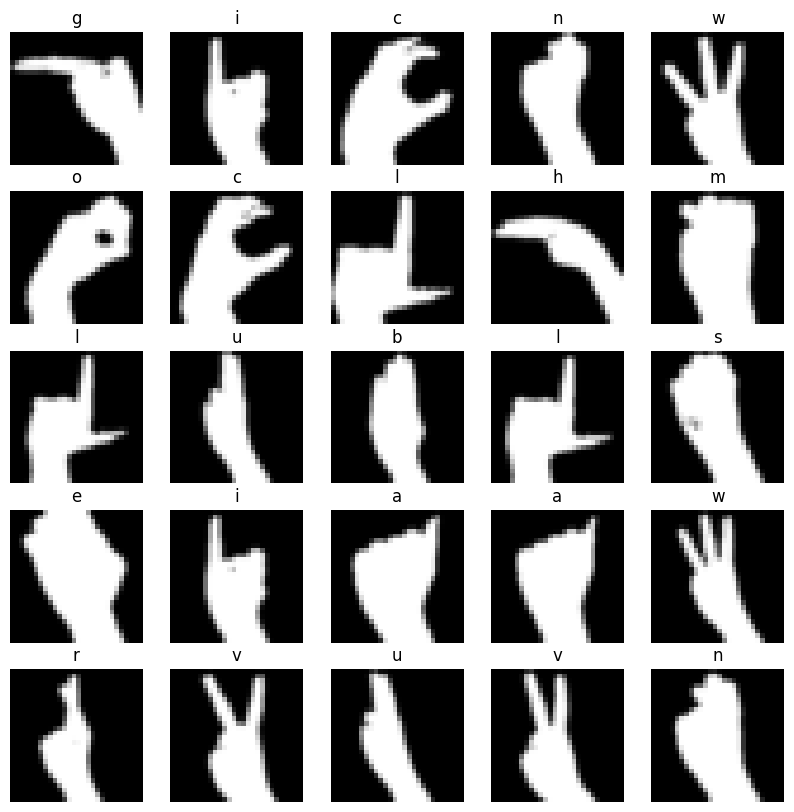

<Figure size 640x480 with 0 Axes>

In [10]:
images, targets = next(iter(train_loader))

vcpi_util.show_images(5,5, images, targets, train_set.classes) 

### Models and Training

In [11]:
# functions taken from notebook 09

def plot_scatter(x,y,targets):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 
                                  'darkgreen', 'yellow', 'brown', 
                                  'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10,10))
    plt.scatter(x, y, c = targets, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()

    plt.show()


def show_preds(set1, set2, count, title):
  
  columns = 4
  rows = int(count*2 / columns) + 1  
  plt.figure(figsize=(count, 2 * rows))
  
  for n in range(count):
      ax = plt.subplot(rows, columns, n*2+1)
      plt.title("original")
      plt.imshow(np.transpose(set1[n].numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*2+2)
      plt.title("reconstruction")
      plt.imshow(np.transpose(set2[n].cpu().detach().numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off') 
      plt.suptitle(title, fontsize=16)  # Add this line to set the title for the entire figure


In [12]:
#CVAE (taken from notebook 11)
#Encoder
class Encoder(torch.nn.Module):

    def __init__(self, latent_space_dim):

        super().__init__()

        # encoder layers
        self.econv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size= 3, stride = 2)
        self.erelu1 = torch.nn.ReLU()
        self.ebn1 = torch.nn.BatchNorm2d(32)

        self.econv2 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size= 3, stride = 2)
        self.erelu2 = torch.nn.ReLU()
        self.ebn2 = torch.nn.BatchNorm2d(64)

        self.efc1_mean = torch.nn.Linear(3136, latent_space_dim)
        self.efc1_log_var = torch.nn.Linear(3136, latent_space_dim)

    def forward(self, x):

        x = torch.nn.functional.pad(x, (0,1,0,1)) # pad left, right, top, bottom
        x = self.econv1(x)
        x = self.ebn1(x)
        x = self.erelu1(x)

        x = torch.nn.functional.pad(x, (0,1,0,1)) # pad left, right, top, bottom
        x = self.econv2(x)
        x = self.ebn2(x)
        x = self.erelu2(x)

        x = torch.flatten(x,1)
        mean = self.efc1_mean(x)
        log_var = self.efc1_log_var(x)

        return mean, log_var
    
#Decoder

class Decoder(torch.nn.Module):

    def __init__(self, latent_space_dim, condition_dim):
        
        super().__init__()

        self.dfc1 = torch.nn.Linear(latent_space_dim + condition_dim, 3136)
        
        self.dconvT1 = torch.nn.ConvTranspose2d(64, 32, 3, 2, padding = 1, output_padding=1)
        self.drelu1 = torch.nn.ReLU()
        self.dbn1 = torch.nn.BatchNorm2d(32)

        self.dconvT2 = torch.nn.ConvTranspose2d(32, 1,3,2, padding = 1, output_padding = 1)
        self.dsig = torch.nn.Sigmoid()


    def forward(self, x, condition):


        x = self.dfc1(torch.cat([x,condition],1))
        x = x.reshape(-1, 64, 7, 7)
        x = self.dconvT1(x)
        x = self.dbn1(x)
        x = self.drelu1(x)

        x = self.dconvT2(x)
        x = self.dsig(x)

        return x 
    
#CVAE

class CVAE(torch.nn.Module):

    def __init__(self, encoder, decoder):

        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def reparametrization(self, mean, var):

        epsilon = torch.randn_like(mean).to(device)    
        z = mean + var * epsilon  
        return z  

    def forward(self, x,condition):

        mean, log_var = self.encoder(x)
        var = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, var)
        output = self.decoder(z, condition)

        return output, mean, log_var


In [13]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)



def train_CVAE(model, train_loader, val_loader, condition_dim, epochs, loss_fn, optimizer, scheduler, early_stopper, save_prefix = 'model'):

    history = {}

    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, labels) in tqdm(enumerate(train_loader, 0)):
            
            inputs = inputs.to(device)
            labels = one_hot(labels, condition_dim)
    
            outputs, mean, log_var = model(inputs, labels)
    
            loss = loss_fn(inputs, outputs, mean, log_var)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()
     
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = one_hot(labels, condition_dim)
                outputs, mean, log_var = model(inputs, labels)
                
                #with torch.no_grad():
                val_loss += loss_fn(inputs, outputs, mean, log_var).cpu().detach().numpy()


        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Val Loss: {val_loss:0.6f}; Elapsed time: {(stop_time - start_time):0.4f}')

        history['val_loss'].append(val_loss)
        history['loss'].append(epoch_loss)
 
        ###### Saving ######
        if val_loss < best_val_loss:
           
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'history': history,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
                },
                f'{save_prefix}_best.pt')
            
            best_val_loss = val_loss
        
        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')
    
    return(history)


class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_val_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False

In [14]:
LATENT_SPACE_DIMS = [2,4,8,16]
class_count = len(train_set.classes)
loss_functions_list = {}
MODELS_FOLDER = 'autoencoder_models'
os.makedirs(MODELS_FOLDER, exist_ok=True)

In [15]:
#################### LOSS FUNCTION 1 ####################
def loss_function_bce_kld(x, output, mean, log_var):
    BCE_loss = torch.nn.BCELoss(reduction = 'sum')
    reproduction_loss = BCE_loss(output, x)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

loss_functions_list['BCE+KLD'] = loss_function_bce_kld

#################### LOSS FUNCTION 2 ####################

def loss_function_mse_kld(x, output, mean, log_var):
    MSE_loss = torch.nn.MSELoss(reduction = 'sum')
    reproduction_loss = MSE_loss(output, x)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

loss_functions_list['MSE+KLD'] = loss_function_mse_kld

#################### LOSS FUNCTION 3 ####################

def loss_function_mae_kld(x, output, mean, log_var):
    reproduction_loss = torch.nn.functional.l1_loss(output, x, reduction = 'sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

loss_functions_list['MAE+KLD'] = loss_function_mae_kld
#################### LOSS FUNCTION 4 ####################

def loss_function_ce_kld(x, output, mean, log_var):
    CE_LOSS = torch.nn.CrossEntropyLoss(reduction='sum')
    reproduction_loss = CE_LOSS(output, x)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

loss_functions_list['CE+KLD'] = loss_function_ce_kld

In [16]:
print(loss_functions_list)
print(LATENT_SPACE_DIMS)

{'BCE+KLD': <function loss_function_bce_kld at 0x000001F33CDBB130>, 'MSE+KLD': <function loss_function_mse_kld at 0x000001F33CDBAF80>, 'MAE+KLD': <function loss_function_mae_kld at 0x000001F33CDBADD0>, 'CE+KLD': <function loss_function_ce_kld at 0x000001F33CDBAD40>}
[2, 4, 8, 16]


In [118]:
for lossFn, loss_function in loss_functions_list.items():
    for LATENT_SPACE_DIM in LATENT_SPACE_DIMS:
        encoder = Encoder(LATENT_SPACE_DIM)
        decoder = Decoder(LATENT_SPACE_DIM, class_count)
        model = CVAE(encoder, decoder).to(device)
        model.to(device)
        model_path = f'{MODELS_FOLDER}/CVAE_model_lossFn={lossFn}_latentDim{LATENT_SPACE_DIM}_condition{class_count}'
        #torchinfo.summary(model, input_size=[(BATCH_SIZE, NUM_CHANNELS, HEIGHT, WIDTH), (BATCH_SIZE, class_count)], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds"])
        
        optimizer = torch.optim.Adam(model.parameters())
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
        early_stop = Early_Stopping(9)
        print(f'Loss function: {lossFn}, Latent space dim: {LATENT_SPACE_DIM}')
        history = train_CVAE(model, train_loader, validation_loader, class_count, EPOCHS, loss_function, optimizer, scheduler, early_stop, save_prefix = model_path)
        print(history.items())


Loss function: MSE+KLD, Latent space dim: 16


0it [00:00, ?it/s]

574it [00:20, 27.91it/s]


Epoch: 000; Loss: 32.072990; Val Loss: 18.833845; Elapsed time: 25.2964


574it [00:20, 27.81it/s]


Epoch: 001; Loss: 17.590252; Val Loss: 16.186120; Elapsed time: 25.6152


574it [00:21, 27.16it/s]


Epoch: 002; Loss: 15.387386; Val Loss: 14.451085; Elapsed time: 25.8593


574it [00:20, 27.59it/s]


Epoch: 003; Loss: 14.038588; Val Loss: 13.306441; Elapsed time: 25.5416


574it [00:20, 28.51it/s]


Epoch: 004; Loss: 13.127294; Val Loss: 12.517266; Elapsed time: 25.3099


574it [00:20, 27.66it/s]


Epoch: 005; Loss: 12.463476; Val Loss: 12.191687; Elapsed time: 25.4964


574it [00:21, 27.15it/s]


Epoch: 006; Loss: 11.998928; Val Loss: 11.792844; Elapsed time: 25.8623


574it [00:19, 29.58it/s]


Epoch: 007; Loss: 11.613689; Val Loss: 11.538480; Elapsed time: 23.9456


574it [00:20, 27.40it/s]


Epoch: 008; Loss: 11.302232; Val Loss: 11.297255; Elapsed time: 25.4409


574it [00:20, 28.61it/s]


Epoch: 009; Loss: 11.044914; Val Loss: 10.793014; Elapsed time: 24.7160
Finished Training
dict_items([('val_loss', [18.83384450422264, 16.186119791433754, 14.451084642823337, 13.306440598317353, 12.517265565839804, 12.191687167771239, 11.792844041934611, 11.53847989724852, 11.297255133381556, 10.793013536481997]), ('loss', [32.072989571526016, 17.590252456631767, 15.387386052513872, 14.038587683317083, 13.127294185220856, 12.463476288750137, 11.998927667470566, 11.613689011691493, 11.302232278989383, 11.044914226473756])])


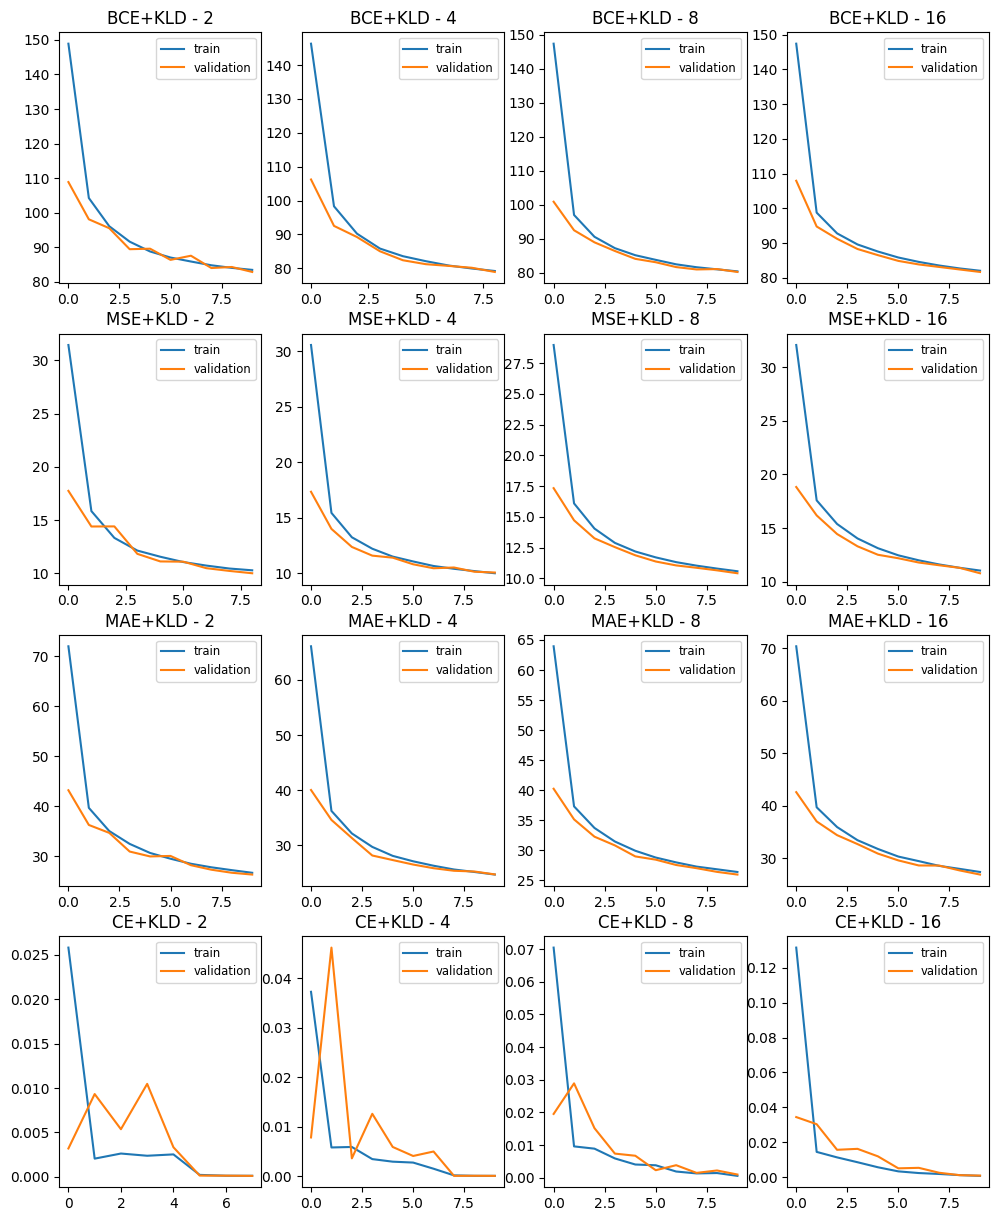

<Figure size 640x480 with 0 Axes>

In [18]:
f, axes= plt.subplots(loss_functions_list.__len__(), LATENT_SPACE_DIMS.__len__(), figsize=(12,15))
fig=plt.figure()

for i, (lossFn, loss_function) in enumerate(loss_functions_list.items()):
    for j, LATENT_SPACE_DIM in enumerate(LATENT_SPACE_DIMS):
        model_save_path = f'{MODELS_FOLDER}/CVAE_model_lossFn={lossFn}_latentDim{LATENT_SPACE_DIM}_condition{class_count}' + '_best.pt'
        reload = torch.load(model_save_path)
        history = reload['history']
        axes[i,j].plot(history['loss'], label='train')
        axes[i,j].plot(history['val_loss'], label='validation')
        axes[i,j].legend(loc='upper right', fontsize='small')
        axes[i,j].set_title(f'{lossFn} - {LATENT_SPACE_DIM}')
        
plt.show()

9
8
9
9
8
9
9
9
9
9
9
9
7
9
9
9


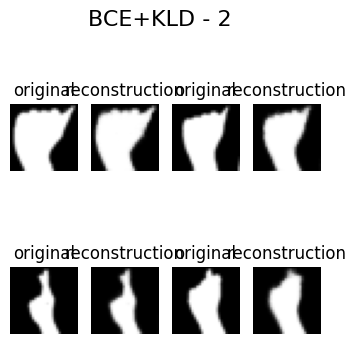

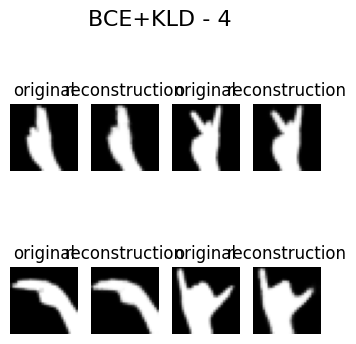

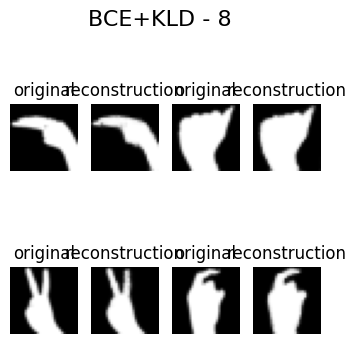

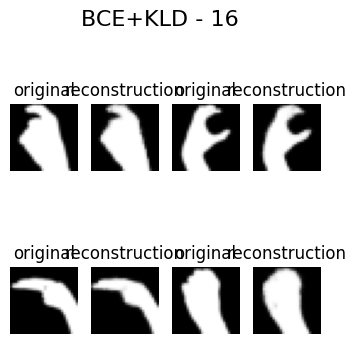

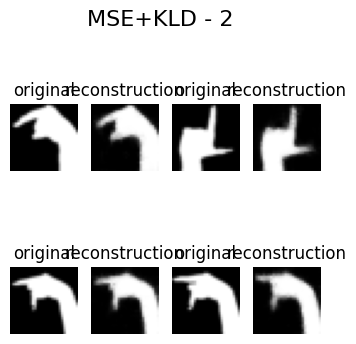

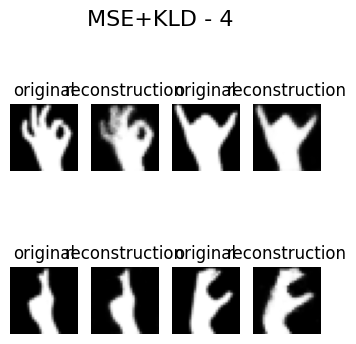

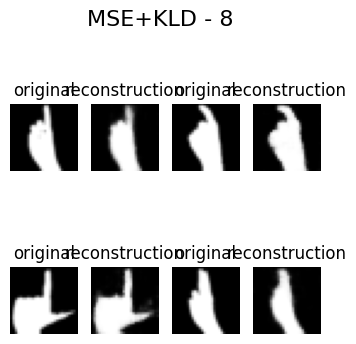

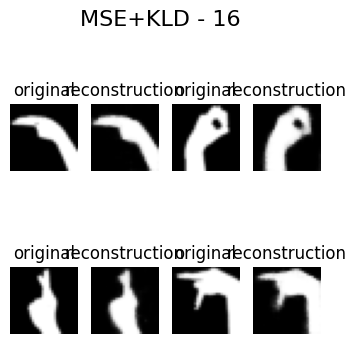

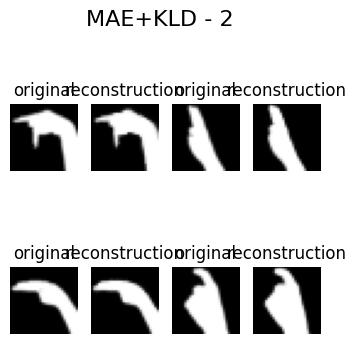

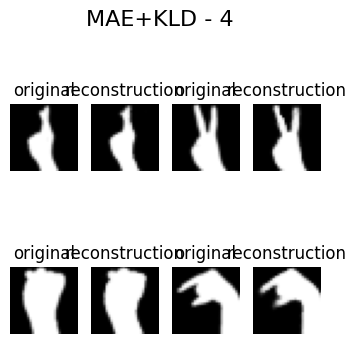

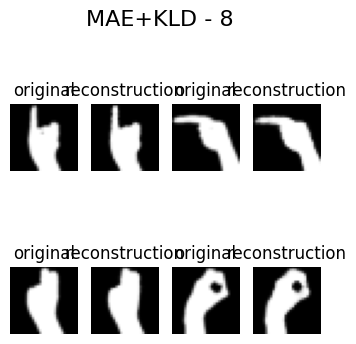

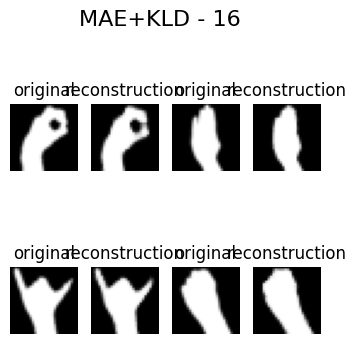

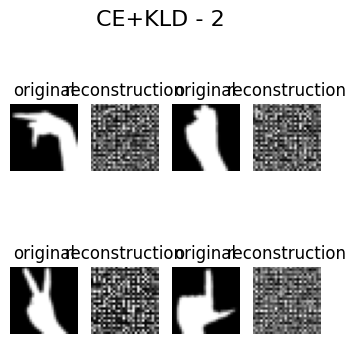

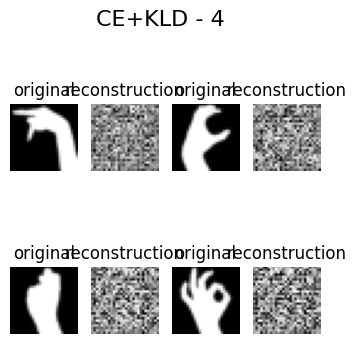

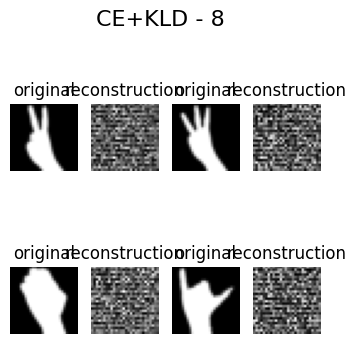

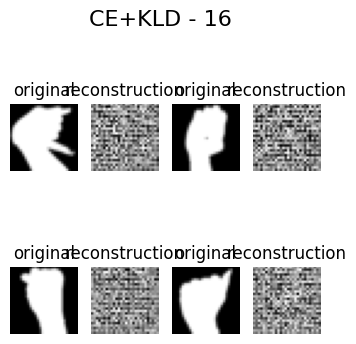

In [124]:
for lossFn, loss_function in loss_functions_list.items():
    for LATENT_SPACE_DIM in LATENT_SPACE_DIMS:
        model_save_path = f'{MODELS_FOLDER}/CVAE_model_lossFn={lossFn}_latentDim{LATENT_SPACE_DIM}_condition{class_count}' + '_best.pt'
        reload = torch.load(model_save_path)
        print(reload['epoch'])
        encoder = Encoder(LATENT_SPACE_DIM)
        decoder = Decoder(LATENT_SPACE_DIM, class_count)
        mCVAE = CVAE(encoder, decoder).to(device)
        mCVAE.to(device)
        mCVAE.load_state_dict(reload['model'])
        
        inputs, labels = next(iter(test_loader))
        recon = mCVAE(inputs.to(device), one_hot(labels, class_count))[0]
        show_preds(inputs, recon, 4, f'{lossFn} - {LATENT_SPACE_DIM}')

##### ADDING SALT AND PEPPER LIKE NOISE TO THE TEST IMAGES

9
8
9
9
8
9
9
9
9
9
9
9
7
9
9
9


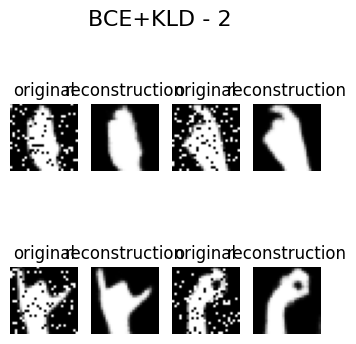

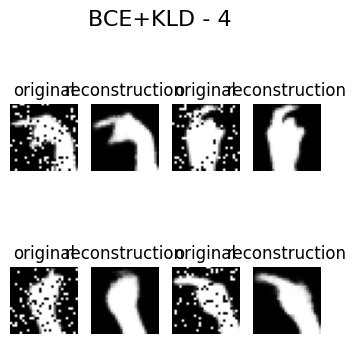

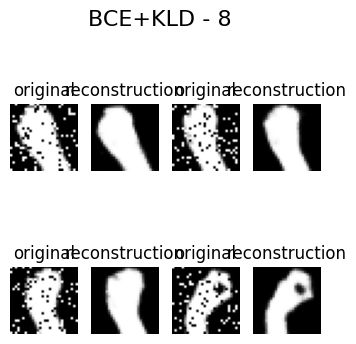

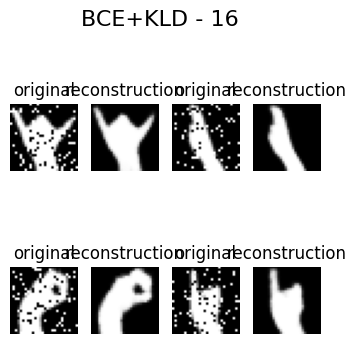

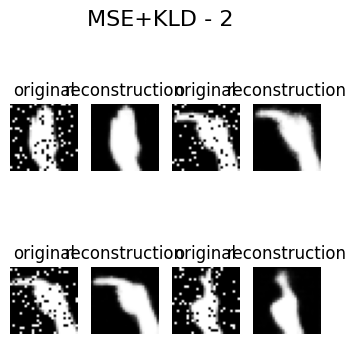

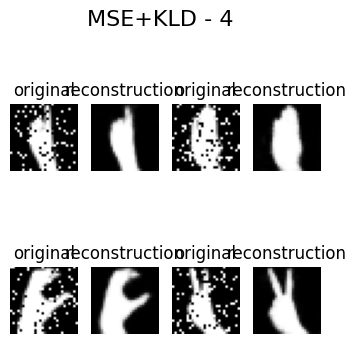

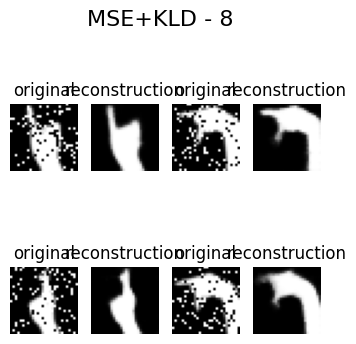

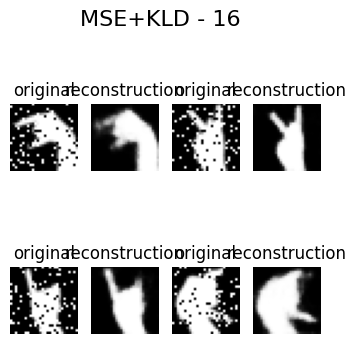

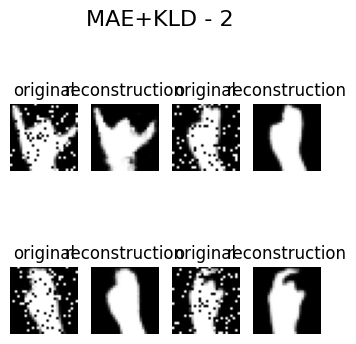

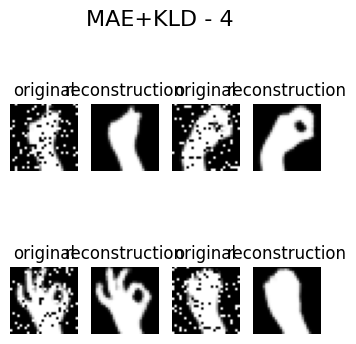

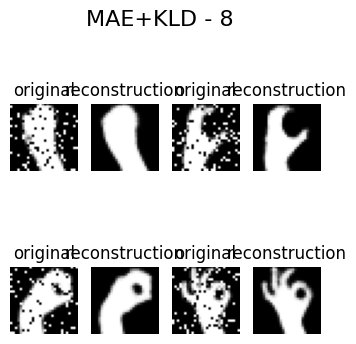

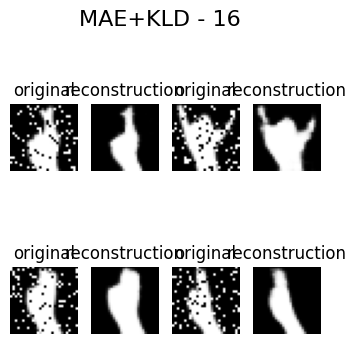

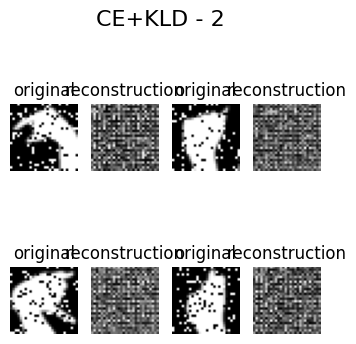

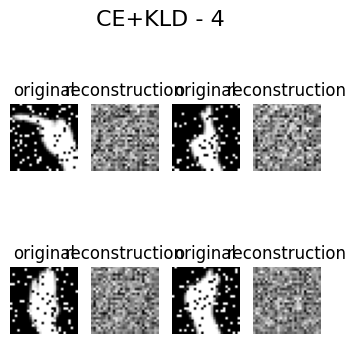

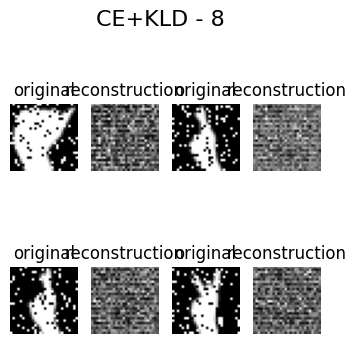

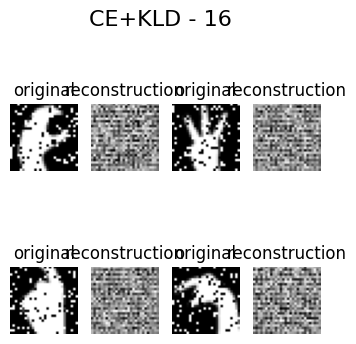

In [19]:
class AddSaltAndPepper(object):
    def __init__(self, amount=0.01):
        self.amount = amount

    def __call__(self, x):
        x_np = x.numpy()  # Convert PyTorch tensor to NumPy array
        noisy_image_np = skimage.util.random_noise(x_np, mode='pepper', amount=self.amount/2)
        noisy_image_np = skimage.util.random_noise(noisy_image_np, mode='salt', amount=self.amount/2)
        noisy_image = torch.from_numpy(noisy_image_np).float()  # Convert NumPy array back to PyTorch tensor
        return noisy_image


transform2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=NUM_CHANNELS),
    transforms.Resize((HEIGHT, WIDTH)),
    transforms.ToTensor(),
    AddSaltAndPepper(amount=0.2)
])

test_set2 = torchvision.datasets.ImageFolder(root=test_path_dest, transform=transform2)
test_loader2 = torch.utils.data.DataLoader(test_set2, batch_size=BATCH_SIZE, shuffle=True)

for lossFn, loss_function in loss_functions_list.items():
    for LATENT_SPACE_DIM in LATENT_SPACE_DIMS:
        model_save_path = f'{MODELS_FOLDER}/CVAE_model_lossFn={lossFn}_latentDim{LATENT_SPACE_DIM}_condition{class_count}' + '_best.pt'
        reload = torch.load(model_save_path)
        print(reload['epoch'])
        encoder = Encoder(LATENT_SPACE_DIM)
        decoder = Decoder(LATENT_SPACE_DIM, class_count)
        mCVAE = CVAE(encoder, decoder).to(device)
        mCVAE.to(device)
        mCVAE.load_state_dict(reload['model'])
        
        inputs, labels = next(iter(test_loader2))
        recon = mCVAE(inputs.to(device), one_hot(labels, class_count))[0]
        show_preds(inputs, recon, 4, f'{lossFn} - {LATENT_SPACE_DIM}')